In [72]:
#Rossmann
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## Exploring Data

In [73]:
#train = pd.read_csv('data/train.csv')
train = pd.read_csv('data/train.csv', parse_dates=True, index_col='Date')
store = pd.read_csv('data/store.csv')

train.shape, store.shape

/Users/bahar/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


((637774, 8), (1115, 10))

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 637774 entries, 2013-01-01 to 2014-07-31
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Store          618473 non-null  float64
 1   DayOfWeek      618757 non-null  float64
 2   Sales          618747 non-null  float64
 3   Customers      618683 non-null  float64
 4   Open           618588 non-null  float64
 5   Promo          618580 non-null  float64
 6   StateHoliday   618520 non-null  object 
 7   SchoolHoliday  618437 non-null  float64
dtypes: float64(7), object(1)
memory usage: 43.8+ MB


In [75]:
train.corr()["Sales"]

Store            0.007023
DayOfWeek       -0.451534
Sales            1.000000
Customers        0.897104
Open             0.675615
Promo            0.450378
SchoolHoliday    0.079535
Name: Sales, dtype: float64

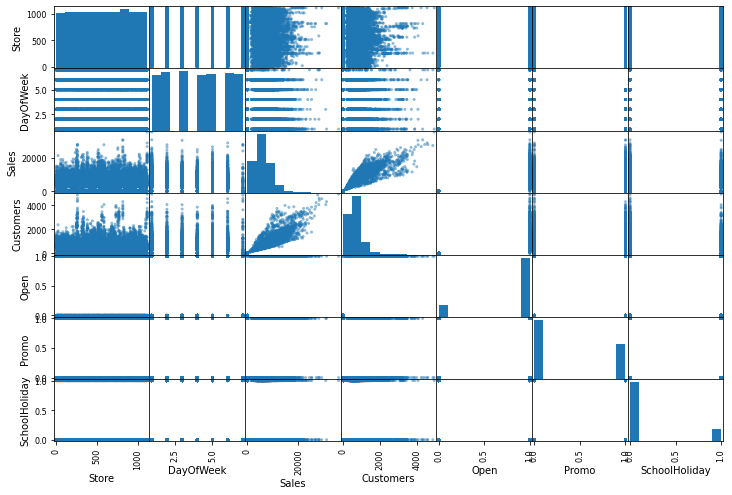

In [76]:
plt.rcParams['figure.figsize'] = [12, 8]
_ = pd.plotting.scatter_matrix(train.sample(n=20_000))

<AxesSubplot:xlabel='Customers', ylabel='Sales'>

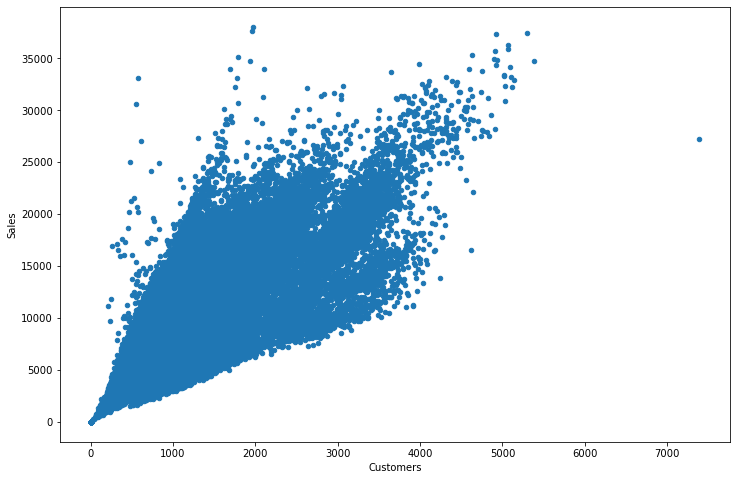

In [77]:
# Customers / Sales looks odd
train.plot.scatter('Customers','Sales')

In [78]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


## Cleaning data


In [79]:

# Drop training data with no store, convert store to int
train.dropna(axis=0, inplace=True, subset=['Store'])
train['Store'] = train['Store'].astype('int')

# Drop training data with no DayOfWeek, convert to int
train.dropna(axis=0, inplace=True, subset=['DayOfWeek'])
train['DayOfWeek'] = train['DayOfWeek'].astype('int')

# Drop train data where store isn't open
train = train[train['Open'] == 1]
train.drop(labels=['Open'], inplace=True, axis=1)

# Drop train data where promo is NaN, convert to int
train.dropna(axis=0, inplace=True, subset=['Promo'])
train['Promo'] = train['Promo'].astype('int')

# Drop SchoolHoliday data where promo is NaN, convert to int
train.dropna(axis=0, inplace=True, subset=['SchoolHoliday'])
train['SchoolHoliday'] = train['SchoolHoliday'].astype('int')

# Drop Params the don't seem useful
store.drop(labels=['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', \
                      'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], inplace=True, axis=1)

# Drop all rows with NaNs - Approx 3% of rows
store.dropna(inplace=True)
train.dropna(inplace=True)

/Users/bahar/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-79-0761ed6cf76f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(axis=0, inplace=True, subset=['Promo'])
<ipython-input-79-0761ed6cf76f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Promo'] =

## Encoding

In [80]:
# Set DayOfWeek to dummy varibles
dummies = pd.get_dummies(train['DayOfWeek'], prefix='DayOfWeek')
train = pd.concat([train, dummies], axis=1)
train.drop(labels=['DayOfWeek'], inplace=True, axis=1)

# Add Month as dummies
dummies = pd.get_dummies(train.index.month, prefix='Month')
dummies.index = train.index
train = pd.concat([train, dummies], axis=1)

# Convert StateHoliday to dummy varibles
dummies = pd.get_dummies(train['StateHoliday'], prefix='StateHoliday')[['StateHoliday_a','StateHoliday_b', 'StateHoliday_c']]
train = pd.concat([train, dummies], axis=1)
train.drop(labels=['StateHoliday'], inplace=True, axis=1)

# Convert StoreType to dummy varibles
dummies = pd.get_dummies(store['StoreType'], prefix='StoreType')
store = pd.concat([store, dummies], axis=1)
store.drop(labels=['StoreType'], inplace=True, axis=1)

# Convert Assortment to dummy varibles
dummies = pd.get_dummies(store['Assortment'], prefix='Assortment')
store = pd.concat([store, dummies], axis=1)
store.drop(labels=['Assortment'], inplace=True, axis=1)

## Concatenate all data

In [86]:
data = pd.merge(train, store, on=["Store"])
data.head()

,Store,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,StateHoliday_b,StateHoliday_c,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,353,3139.0,820.0,0,1,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,353,2686.0,835.0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,353,2628.0,815.0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
3,353,2677.0,856.0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,353,2224.0,719.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [87]:
data.isna().sum() / data.shape[0]

Store             0.0
Sales             0.0
Customers         0.0
Promo             0.0
SchoolHoliday     0.0
DayOfWeek_1       0.0
DayOfWeek_2       0.0
DayOfWeek_3       0.0
DayOfWeek_4       0.0
DayOfWeek_5       0.0
DayOfWeek_6       0.0
DayOfWeek_7       0.0
Month_1           0.0
Month_2           0.0
Month_3           0.0
Month_4           0.0
Month_5           0.0
Month_6           0.0
Month_7           0.0
Month_8           0.0
Month_9           0.0
Month_10          0.0
Month_11          0.0
Month_12          0.0
StateHoliday_a    0.0
StateHoliday_b    0.0
StateHoliday_c    0.0
Promo2            0.0
StoreType_a       0.0
StoreType_b       0.0
StoreType_c       0.0
StoreType_d       0.0
Assortment_a      0.0
Assortment_b      0.0
Assortment_c      0.0
dtype: float64

In [89]:
data.corr()["Sales"]

Store             0.010607
Sales             1.000000
Customers         0.827437
Promo             0.371947
SchoolHoliday     0.038049
DayOfWeek_1       0.179800
DayOfWeek_2       0.009035
DayOfWeek_3      -0.027653
DayOfWeek_4      -0.027077
DayOfWeek_5       0.020897
DayOfWeek_6      -0.155523
DayOfWeek_7       0.019930
Month_1          -0.049661
Month_2          -0.030697
Month_3           0.009990
Month_4           0.006029
Month_5           0.019018
Month_6          -0.000008
Month_7           0.008845
Month_8          -0.019391
Month_9          -0.035630
Month_10         -0.027900
Month_11          0.004675
Month_12          0.131974
StateHoliday_a    0.013591
StateHoliday_b    0.011653
StateHoliday_c    0.003619
Promo2           -0.128749
StoreType_a       0.001513
StoreType_b       0.134741
StoreType_c      -0.003154
StoreType_d      -0.038005
Assortment_a     -0.092825
Assortment_b      0.041824
Assortment_c      0.084749
Name: Sales, dtype: float64

## Feature Engineering Conclusion

1-Sales are cyclic yearly and weekly \
2-Sales are specific to each store type (type b is selling significantly more)

## Test / Train Split

In [90]:
import numpy as np
from sklearn.model_selection import train_test_split

X=data.drop('Sales', axis=1)
y=data['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)